# Optimizing the K parameter for K-means with iris data set

## Jonne Pohjankukka

In [1]:
#***********************************************#

## Make notebook wider for better presentation ##

#***********************************************#
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

In [2]:
#***********************************************#

##     Import libraries and edit settings      ##

#***********************************************#
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets.samples_generator import make_blobs
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from IPython.display import display, clear_output
from sklearn.metrics import pairwise_distances
from sklearn import metrics
from matplotlib import gridspec
from sklearn import datasets
from IPython.display import display, HTML
np.warnings.filterwarnings('ignore') # Due to NaNs in arrays
pd.set_option('display.max_rows', None)
%matplotlib inline
maximum_k_value_to_test = 6

In [3]:
#***********************************************#

##  Define helper functions for the analysis   ##

#***********************************************#


#################################################
#
# We use this funtion for generating artificial 
# cluster data to test if our analysis is working 
# correctly.
#
# -- Parameters -- 
# centers (positive integer > 1): defines the number
# of artificially generated cluster centers 
#
# -- Returns --
# X: 2D cluster data
# y: label data
#
#################################################
def makeTestClusterData(centers):
    X, y = make_blobs(n_samples=centers*100, centers=centers, cluster_std=1.0, random_state=None)
    return X, y

#################################################
#
# Inertia calculation required for 'compute_gap'
# -function. Cited function:
# https://glowingpython.blogspot.com/2019/01/a-visual-introduction-to-gap-statistics.html
#
# -- Parameters -- 
# labels: label data of clusters
# X: Feature matrix data
#
# -- Returns --
# inertia value
#
#################################################
def compute_inertia(labels, X):
    W = [np.mean(pairwise_distances(X[labels == c, :])) for c in np.unique(labels)]
    return np.mean(W)

#################################################
#
# Function for caluclating the 'Gap statistic'-
# metric. Cited function: 
# https://glowingpython.blogspot.com/2019/01/a-visual-introduction-to-gap-statistics.html
#
# -- Parameters -- 
# clustering: Kmeans object
# data: Feature data
# k_max: maximum number of Kmeans centroids to try
# n_references: 
#
# -- Returns --
# Gap statistics, inertia values
#
#################################################
def compute_gap(clustering, data, k_max=5, n_references=5):
    if len(data.shape) == 1:
        data = data.reshape(-1, 1)
    reference = np.random.rand(*data.shape)
    reference_inertia = []
    for k in range(1, k_max+1):
        local_inertia = []
        for _ in range(n_references):
            clustering.n_clusters = k
            assignments = clustering.fit_predict(reference)
            local_inertia.append(compute_inertia(assignments, reference))
        reference_inertia.append(np.mean(local_inertia))
    
    ondata_inertia = []
    for k in range(1, k_max+1):
        clustering.n_clusters = k
        assignments = clustering.fit_predict(data)
        ondata_inertia.append(compute_inertia(assignments, data))
        
    gap = np.log(reference_inertia)-np.log(ondata_inertia)
    return gap, np.log(reference_inertia), np.log(ondata_inertia)

#################################################
#
# Function for choosing the optimal k for
# Elbow metric using linear regression. 
# Optimal point is where curve starts to follow
# approximately linear curve (Elbow point).
#
# -- Parameters -- 
# distortion_metric: contains k and elbow values
#
# -- Returns --
# optimal elbow k value (integer)
#
#################################################
def getOptimalElbowK(distortion_metric):
    mse_vals = []
    regr = linear_model.LinearRegression()
    for ind in range(distortion_metric.shape[0]-1):
        regr.fit(distortion_metric[ind:,0].reshape(-1, 1), distortion_metric[ind:,1])
        pred = regr.predict(distortion_metric[ind:,0].reshape(-1, 1))
        # The mean squared error
        mse_vals.append(mean_squared_error(distortion_metric[ind:,1], pred))
    mse_diffs = []
    for ind in range(len(mse_vals)-1):
        mse_diffs.append(np.abs(mse_vals[ind]-mse_vals[ind+1]))
    diff_threshold = (np.max(mse_vals)-np.min(mse_vals))*0.025
    opt_k_ind = np.where(np.array(mse_diffs)  < diff_threshold)[0]
    if len(opt_k_ind) > 0:
        return np.int(distortion_metric[opt_k_ind[0],0])
    else:
        return 0

#################################################
#
# Function for choosing the optimal k using all
# three metrics. Returns a weighted average of the
# three. The value is rounded to nearest integer
#
# -- Parameters -- 
# metric_array: contains metric data
# metric_weights: contains weights for calculation
# sum(weights) = 1.0
#
# -- Returns --
# weighted average of optimal k values of three 
# metrics
#
#################################################
def getOptimalK(metric_array, metric_weights):
    opt_silh_ind = np.where(metric_array[:,1] == np.max(metric_array[:,1]))[0]
    opt_gap_ind = np.where(metric_array[:,3] == np.max(metric_array[:,3]))[0]
    opt_silh_k = float(metric_array[opt_silh_ind,0][0])
    opt_dist_k = float(getOptimalElbowK(metric_array[:,[0,2]]))
    opt_gap_k = float(metric_array[opt_gap_ind,0][0])
    if opt_dist_k == 0.0:
        opt_dist_k = (opt_silh_k + opt_gap_k) / 2.0
    kvector = np.array([[opt_silh_k, opt_dist_k, opt_gap_k]])
    # w1 * silh + w2 * dist + w3 * gap
    return np.int(np.round(np.dot(metric_weights, np.transpose(kvector))))
    
#################################################
#
# Function for producing a 3 x 2 figure of the 
# car data. 
#
# -- Parameters -- 
# data: Feature matrix 
# labels: Names for the columns in 'data'
#
#################################################
def plotData(data, labels):
    ind = 0 # Running index for plotting
    colors = ["blue", "red", "orange", "green", "purple", "brown"] # Colors for plotting purposes
    rows = 3
    cols = 2
    fig, axes = plt.subplots(rows,cols)
    fig.set_size_inches(16, 15)
    for row in range(rows): 
        for col in range(cols):
            # Plot the current data
            axes[row,col].plot(range(1,data.shape[0]+1), data[:,ind], color=colors[ind],label=labels[ind])
            axes[row,col].grid(True)
            axes[row,col].legend(shadow=True, fancybox=True, prop={'size': 12})
            axes[row,col].set(xlabel='CarID', ylabel=labels[ind])
            ind += 1            

#################################################
#
# Function for cluster analysis of the car data.
#
# -- Parameters -- 
# data: 2D cluster data
# krange: range of k values to test
#
# -- Returns --
# metric_array: matrix containing all metric values
# silhouette, distortion (Elbow), Gap 
#
#################################################
def metricAnalysis(data, krange):
    silhouette_scores = {}
    distortion_scores = {}
    gap_scores, reference_inertia, ondata_inertia = compute_gap(KMeans(), data, k_max=np.max(krange), n_references=np.max(krange))
    for k in krange:
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=100, tol=10^-8)
        kmeans.fit(data)
        #silhouette_score = metrics.silhouette_score(data, kmeans.labels_,metric='euclidean',sample_size=data.shape[0]-100)
        silhouette_scores[k] = metrics.silhouette_score(data, kmeans.labels_)   
        distortion_scores[k] = kmeans.inertia_
    metric_array = np.zeros((len(krange), 4))
    metric_array[:,0] = krange
    metric_array[:,1] = list(silhouette_scores.values())
    metric_array[:,2] = list(distortion_scores.values())
    metric_array[:,3] = gap_scores[1:]
    return metric_array

#################################################
#
# Function for visualizing metric data.
#
# -- Parameters -- 
# metric_array: matrix containing all metric values
# silhouette, distortion (Elbow), Gap 
#
#################################################
def plotMetricArray(metric_array):
    fig, axes = plt.subplots(1,3)
    fig.set_size_inches(19, 5)
    axes[0].plot(metric_array[:,0], metric_array[:,1], color="red")
    axes[0].grid(True)
    axes[0].set(xlabel='Cluster k parameter value', ylabel='Silhouette value')
    axes[1].plot(metric_array[:,0], metric_array[:,2], color="blue")
    axes[1].grid(True)
    axes[1].set(xlabel='Cluster k parameter value', ylabel='Distortion value')
    axes[2].plot(metric_array[:,0], metric_array[:,3], color="green")
    axes[2].grid(True)
    axes[2].set(xlabel='Cluster k parameter value', ylabel='Gap statistic value') 
    plt.show()

Initial testing of analysis tools. Below you can see an example of artificially produced cluster data.
We will use artificial data to verify that the analysis algorithms are working correctly.


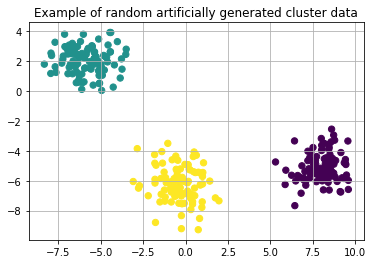

In [4]:
#***********************************************#

##     Initial testing of analysis tools       ##

#***********************************************#
print("Initial testing of analysis tools. Below you can see an example of artificially produced cluster data.")
print("We will use artificial data to verify that the analysis algorithms are working correctly.")
# Give an example of artifical cluster data
test_data_cluster_centers = 3
cluster_X, cluster_y = makeTestClusterData(test_data_cluster_centers)
cluster_X = cluster_X[:, ::-1] # flip axes for better plotting
# Plot the data with K Means Labels
kmeans = KMeans(test_data_cluster_centers)
labels = kmeans.fit(cluster_X).predict(cluster_X)
plt.scatter(cluster_X[:, 0], cluster_X[:, 1], c=labels, s=40);
plt.grid(True)
plt.title("Example of random artificially generated cluster data");

Next, we will apply three widely used clusterization metrics for K-parameter selection in Kmeans: Silhoutte, Elbow and Gap Statistic method.

Below you can see the metric graphs for the above created artificial cluster data:



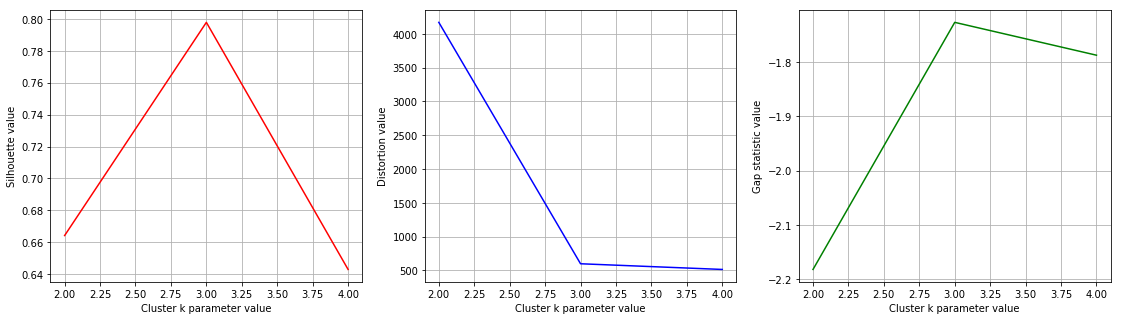

For Silhouette and Gap value, the k parameter with highest value should be selected. For the Elbow method, the k parameter should be selected at the point when the distortion graph starts to behave in a linear manner.

We will next solve the optimal k-value for Kmeans by taking the weighted average of these three metrics using the artificial data. We will give more weight to Elbow and Gap statistics since they seem to perform many times better than the Silhouette method.

Calculating optimal k-parameter...

The optimal k parameter for the artificially generated data was k = 3, which indeed is correct!

We will next analyse the real world iris data.



In [5]:
#***********************************************#

##      Visualizing cluster metrics            ##

#***********************************************#
print("Next, we will apply three widely used clusterization metrics for K-parameter selection in Kmeans: Silhoutte, Elbow and Gap Statistic method.\n")
print("Below you can see the metric graphs for the above created artificial cluster data:\n")
# Do cluster parameter selection
metric_array = metricAnalysis(cluster_X, range(2,5))
plotMetricArray(metric_array)
# Get the optimal k value by using weighted average of the three metrics
silh_w = 0.2
dist_w = 0.4 
gap_w = 0.4
weights = np.array([[silh_w, dist_w, gap_w]])
print("For Silhouette and Gap value, the k parameter with highest value should be selected. For the Elbow method, the k parameter should be selected " 
      "at the point when the distortion graph starts to behave in a linear manner.\n")
print("We will next solve the optimal k-value for Kmeans by taking the weighted average of these three metrics using the artificial data. "
     "We will give more weight to Elbow and Gap statistics since they seem to perform many times better than the Silhouette method.\n")
print("Calculating optimal k-parameter...\n")
voted_optimal_k = getOptimalK(metric_array, weights)
if voted_optimal_k == test_data_cluster_centers:
    print("The optimal k parameter for the artificially generated data was k = " + str(voted_optimal_k) + ", which indeed is correct!\n")
else:
    print("The optimal k parameter for the artificially generated data was k = " + str(voted_optimal_k) + ", which is not correct. "
          "Here we see that even though the metrics are robust, they do not always succeed. \n")
print("We will next analyse the real world iris data.\n")

In [6]:
# Load the iris data
iris = datasets.load_iris()
data_matrix = iris['data']
data_matrix = data_matrix[:,0:4]

In [7]:
print("\n--- STEP 2: NORMALIZE THE DATA --- \n")
print("We will next normalize the features of the iris data in order to guarantee that all features "
      "have same weight in the analysis process.\nWe have no prior reason to assume that one feature would have higher weight than other in the iris data.\n")
# Standardize the data to N(0,1)
scaler = StandardScaler()
scaled_analysis_data = scaler.fit_transform(data_matrix)
print("The data has now been normalized.\n")


--- STEP 2: NORMALIZE THE DATA --- 

We will next normalize the features of the iris data in order to guarantee that all features have same weight in the analysis process.
We have no prior reason to assume that one feature would have higher weight than other in the iris data.

The data has now been normalized.




--- STEP 3: VISUALIZE DATA IN LOWER DIMENSION ---

Let us next visualize the data in 3D-space with the hopes that dimensionality reduction does not remove too much variance of the data.

Performing principal component analysis of the iris data...

After PCA we notice that 99.48% of the iris data variance is contained within 3D-space
so we should get a pretty good idea what the data actually looks like.

Plotting the iris group data in various angles in 3D PCA space:



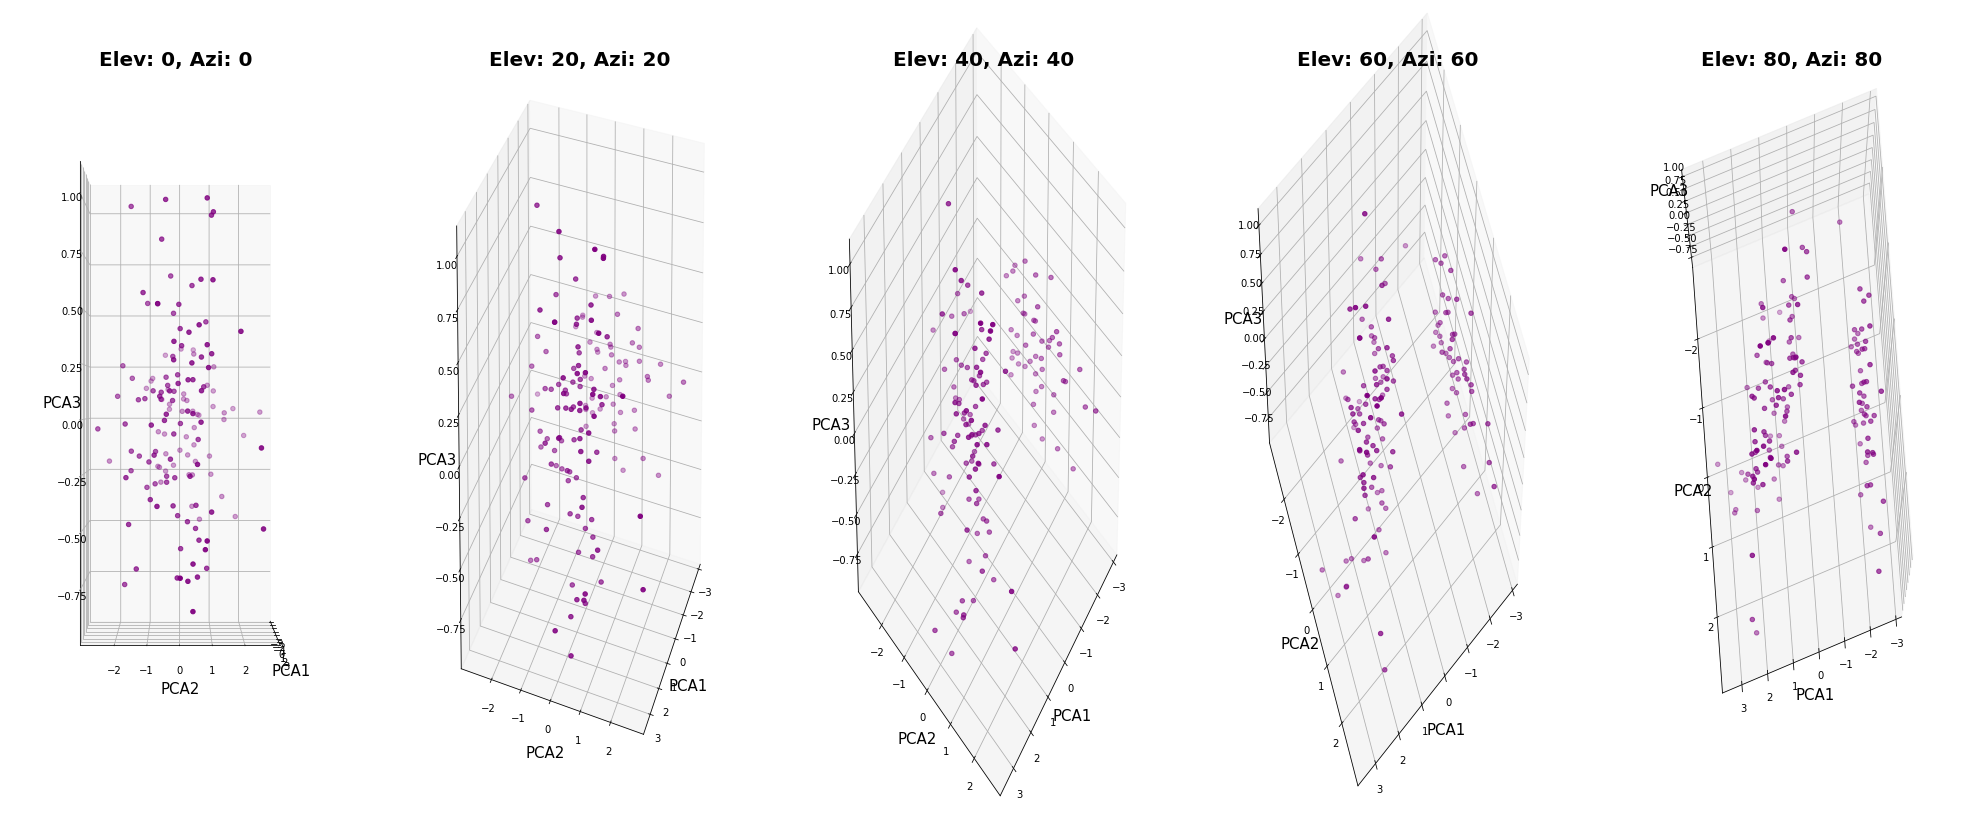

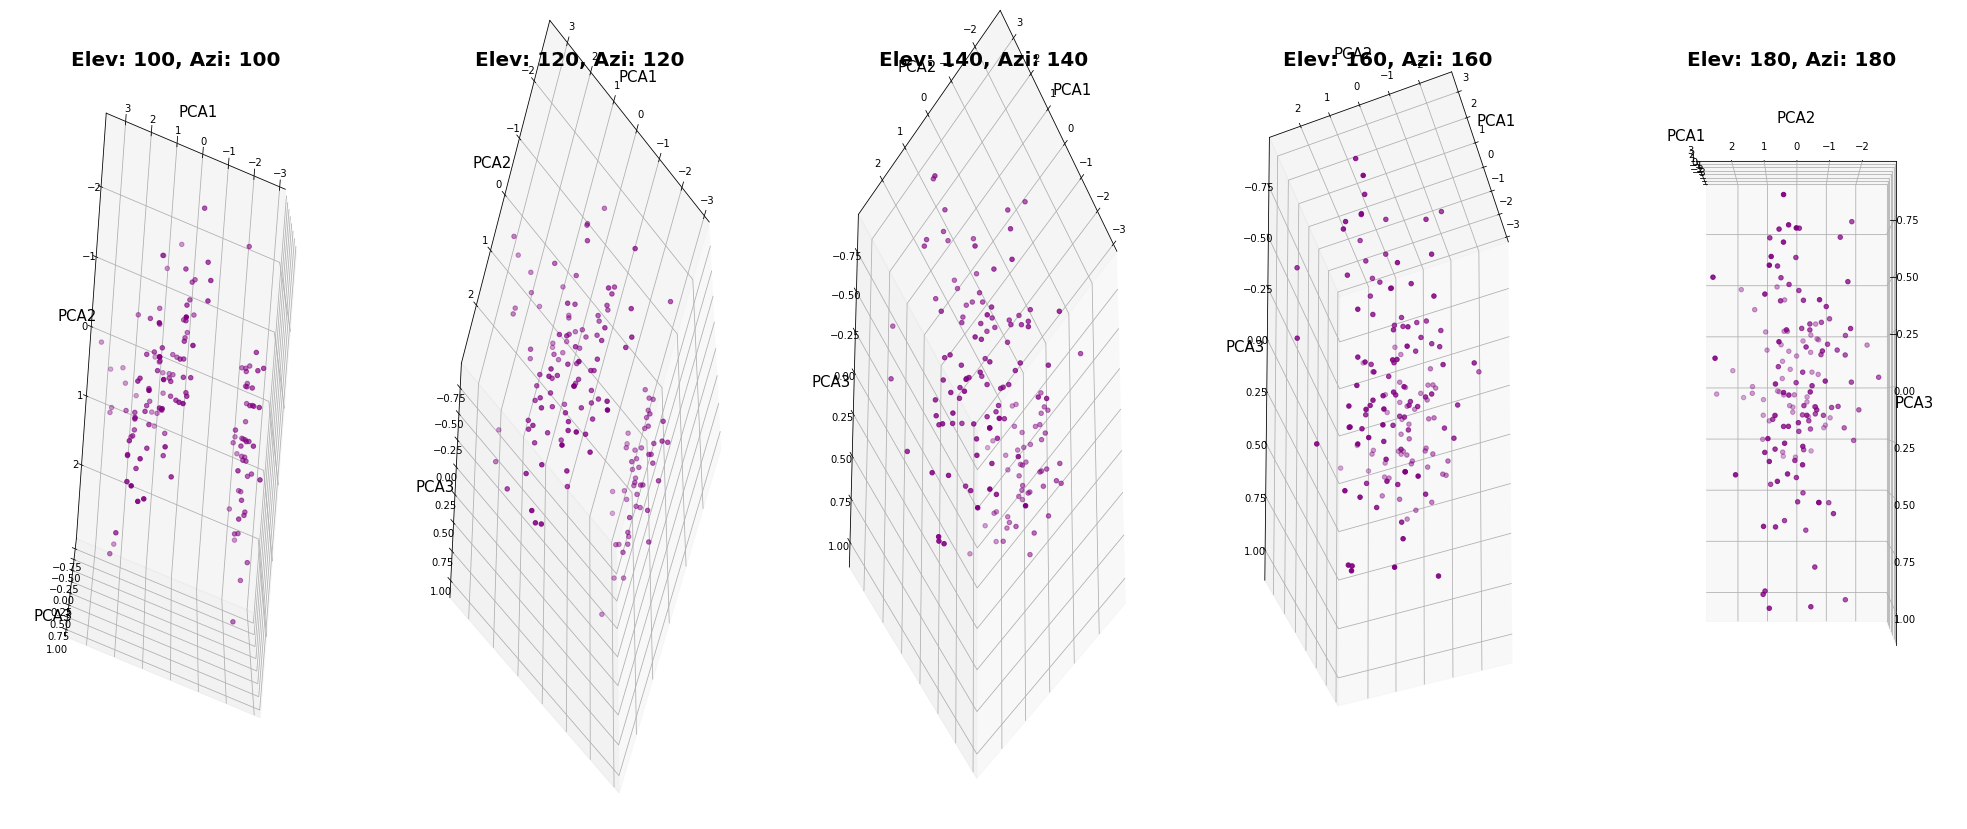

In [8]:
print("\n--- STEP 3: VISUALIZE DATA IN LOWER DIMENSION ---\n")
print("Let us next visualize the data in 3D-space with the hopes that dimensionality reduction does not remove too much variance of the data.\n")
print("Performing principal component analysis of the iris data...\n")
pca = PCA(n_components=data_matrix.shape[1])
pca.fit(scaled_analysis_data)
variances = pca.explained_variance_ratio_
print("After PCA we notice that " + str(np.round(np.sum(variances[0:3])*100, 2)) + "% of the iris data variance is contained within 3D-space\n"
     "so we should get a pretty good idea what the data actually looks like.\n")
print("Plotting the iris group data in various angles in 3D PCA space:\n")
reduced_data = PCA(n_components=3).fit_transform(scaled_analysis_data)
fig = plt.figure()
fig.set_size_inches(35, 15)
elevs = range(0, 100, 20)
azims = range(0, 100, 20)
for i in range(len(elevs)):
    ax = fig.add_subplot(1, len(elevs), i+1, projection='3d')
    ax.view_init(elev=elevs[i], azim=azims[i])
    ax.scatter3D(reduced_data[:,0], reduced_data[:,1], reduced_data[:,2], c="purple");
    ax.set_title("Elev: " + str(elevs[i]) + ", Azi: " + str(azims[i]),fontweight="bold", size=20) # Title
    ax.set_xlabel('PCA1', fontsize = 15) 
    ax.set_ylabel('PCA2', fontsize = 15) 
    ax.set_zlabel('PCA3', fontsize = 15) 
plt.show()
fig = plt.figure()
fig.set_size_inches(35, 15)
elevs = range(100, 200, 20)
azims = range(100, 200, 20)
for i in range(len(elevs)):
    ax = fig.add_subplot(1, len(elevs), i+1, projection='3d')
    ax.view_init(elev=elevs[i], azim=azims[i])
    ax.scatter3D(reduced_data[:,0], reduced_data[:,1], reduced_data[:,2], c="purple");
    ax.set_title("Elev: " + str(elevs[i]) + ", Azi: " + str(azims[i]),fontweight="bold", size=20) # Title
    ax.set_xlabel('PCA1', fontsize = 15) 
    ax.set_ylabel('PCA2', fontsize = 15) 
    ax.set_zlabel('PCA3', fontsize = 15) 
plt.show()

In [9]:
print("\n--- STEP 4: CALCULATE METRIC WEIGHTING ---\n")
print("I will calculate via simulation, which k selection metric performs\nthe best generally and should thus be given most weight in k selection.")
number_of_experiments = 10
k_experiment_range = range(2, maximum_k_value_to_test+1)
total_number_of_experiments = number_of_experiments * len(k_experiment_range)
metric_score_matrix = np.zeros((total_number_of_experiments, 3))
experiment_index = 0
print("Implementing metric performance simulation test...\n")


--- STEP 4: CALCULATE METRIC WEIGHTING ---

I will calculate via simulation, which k selection metric performs
the best generally and should thus be given most weight in k selection.
Implementing metric performance simulation test...



'Running metric comparison analysis: 50/50'

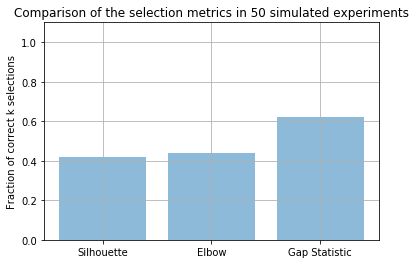

In [10]:
for i in range(number_of_experiments):
    for k in k_experiment_range:
        clear_output(wait=True)
        display("Running metric comparison analysis: " + str(experiment_index+1) + "/" + str(total_number_of_experiments))
        cluster_X, cluster_y = makeTestClusterData(k)
        metric_array = metricAnalysis(cluster_X, k_experiment_range)
        opt_silh_ind = np.where(metric_array[:,1] == np.max(metric_array[:,1]))[0]
        opt_gap_ind = np.where(metric_array[:,3] == np.max(metric_array[:,3]))[0]
        opt_silh_k = float(metric_array[opt_silh_ind,0][0])
        opt_dist_k = float(getOptimalElbowK(metric_array[:,[0,2]]))
        opt_gap_k = float(metric_array[opt_gap_ind,0][0])
        if opt_dist_k == 0.0:
            opt_dist_k = (opt_silh_k + opt_gap_k) / 2.0
        if opt_silh_k == k:
            metric_score_matrix[experiment_index,0] = 1.0
        if opt_dist_k == k:
            metric_score_matrix[experiment_index,1] = 1.0
        if opt_gap_k == k:
            metric_score_matrix[experiment_index,2] = 1.0
        experiment_index += 1
sum_scores = np.sum(metric_score_matrix, axis=0) / float(total_number_of_experiments)
objects = ('Silhouette', 'Elbow', 'Gap Statistic')
y_pos = np.arange(len(objects))
plt.bar(y_pos, sum_scores, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Fraction of correct k selections')
plt.title('Comparison of the selection metrics in ' + str(total_number_of_experiments) + ' simulated experiments')
plt.ylim([0, 1.1])
plt.grid(True)
plt.show()


--- STEP 5: CALCULATE METRIC WEIGHTING AND CHOOSE OPTIMAL K PARAMETER ---

Implementing Kmeans parameter selection from range K = 2-6...

Metric graphs for the iris data:



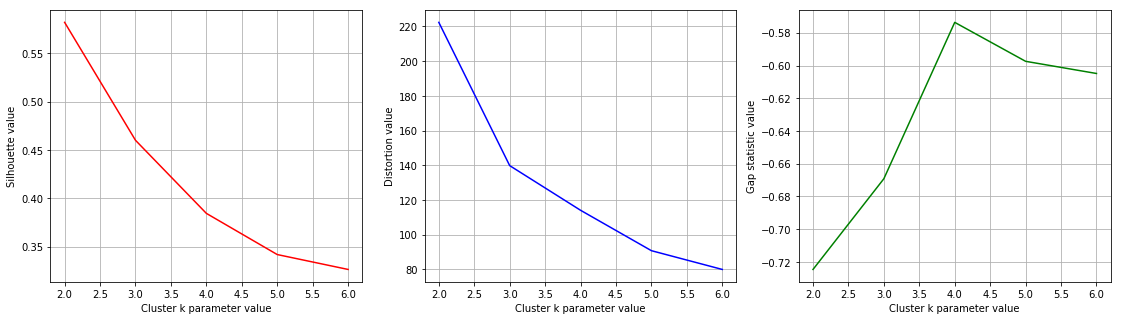

The calculated (via simulation experiments above) k parameter weights for the three metrics are : [0.28378378 0.2972973  0.41891892]

Thus the optimal calculated k parameter for Kmeans is: --[ 3 ]-- clusters.

Next, we will produce Kmeans clustering for the iris data with  cluster centers.



In [11]:
print("\n--- STEP 5: CALCULATE METRIC WEIGHTING AND CHOOSE OPTIMAL K PARAMETER ---\n")
silh_w = sum_scores[0]/np.sum(sum_scores)
dist_w = sum_scores[1]/np.sum(sum_scores)
gap_w = sum_scores[2]/np.sum(sum_scores)
weights = np.array([[silh_w, dist_w, gap_w]])
k_search_range = range(2, maximum_k_value_to_test+1)
print("Implementing Kmeans parameter selection from range K = " + str(np.min(k_search_range)) + "-" + str(np.max(k_search_range)) + "...\n")
metric_array = metricAnalysis(scaled_analysis_data, k_search_range)
print("Metric graphs for the iris data:\n")
plotMetricArray(metric_array)
print("The calculated (via simulation experiments above) k parameter weights for the three metrics are : " + str(weights[0]) + "\n")
# Get the optimal k value by using weighted average of the three metrics
voted_optimal_k = getOptimalK(metric_array, weights)
print("Thus the optimal calculated k parameter for Kmeans is: --[ " + str(voted_optimal_k) +  " ]-- clusters.\n")
print("Next, we will produce Kmeans clustering for the iris data with " + str() + " cluster centers.\n")

In [12]:
print("\n--- STEP 6: PERFORM K MEANS CLUSTERING FOR THE IRIS DATA ---\n")
kmeans = KMeans(init='k-means++', n_clusters=voted_optimal_k, n_init=1000)
kmeans.fit(scaled_analysis_data)
print("Done fitting Kmeans model to data.\n")


--- STEP 6: PERFORM K MEANS CLUSTERING FOR THE IRIS DATA ---

Done fitting Kmeans model to data.




--- STEP 7: PLOT THE CLUSTERING RESULTS IN 2D/3D PCA SPACE VIA VORONOI TESSELATION---

Cluster centroids are marked with larger filled spheres.



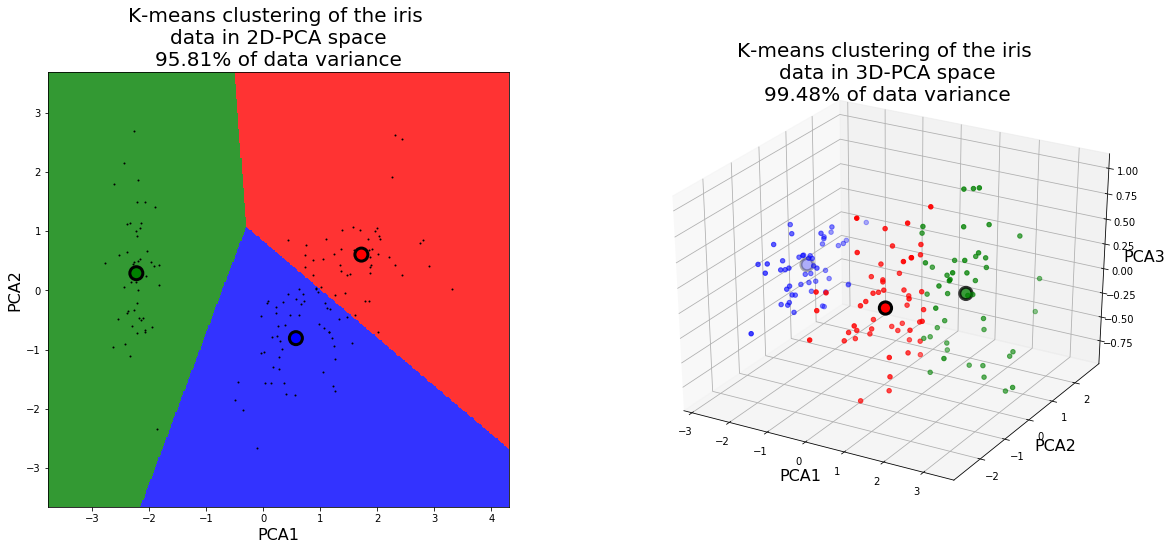

In [13]:
print("\n--- STEP 7: PLOT THE CLUSTERING RESULTS IN 2D/3D PCA SPACE VIA VORONOI TESSELATION---\n")
print("Cluster centroids are marked with larger filled spheres.\n")
# Do 2D PCA
reduced_data = PCA(n_components=2).fit_transform(scaled_analysis_data)
kmeans_2dim = KMeans(init='k-means++', n_clusters=voted_optimal_k, n_init=1000)
kmeans_2dim.fit(reduced_data)
# Plot reduced data in 2d plot
fig = plt.figure()
fig.set_size_inches(20, 8)
spec = gridspec.GridSpec(ncols=2, nrows=1, width_ratios=[1, 1.2])
ax = fig.add_subplot(spec[0])
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].
# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans_2dim.predict(np.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
Z = Z.reshape(xx.shape)
colors = ['red','green','blue']
if voted_optimal_k != 3:
    colors = np.random.rand(voted_optimal_k,3)
ax.imshow(Z, interpolation='nearest',extent=(xx.min(), xx.max(), yy.min(), yy.max()),cmap=matplotlib.colors.ListedColormap(colors),aspect='auto', origin='lower', alpha=0.8)
ax.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as larger spheres
centroids = kmeans_2dim.cluster_centers_
ax.scatter(centroids[:, 0], centroids[:, 1], marker='o', s=169, linewidths=3, c=colors, edgecolor='black', zorder=10)
ax.set_title('K-means clustering of the iris \ndata in 2D-PCA space\n' + str(np.round(np.sum(variances[0:2])*100, 2)) + '% of data variance')
ax.title.set_size(20)
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xlabel("PCA1")
ax.set_ylabel("PCA2")
# Do 3D PCA
reduced_data = PCA(n_components=3).fit_transform(scaled_analysis_data)
kmeans_3dim = KMeans(init='k-means++', n_clusters=voted_optimal_k, n_init=1000)
kmeans_3dim.fit(reduced_data)
# Plot reduced data in 3d plot
ax = fig.add_subplot(spec[1], projection="3d")
Z = kmeans_3dim.predict(reduced_data)
ax.scatter3D(reduced_data[:,0], reduced_data[:,1], reduced_data[:,2], c=Z, cmap=matplotlib.colors.ListedColormap(colors));
centroids = kmeans_3dim.cluster_centers_
ax.scatter3D(centroids[:, 0], centroids[:, 1], marker='o', s=150, linewidths=3, c=colors, edgecolor='black', zorder=0)
ax.set_xlabel('PCA1') 
ax.set_ylabel('PCA2') 
ax.set_zlabel('PCA3')
ax.set_title('K-means clustering of the iris \ndata in 3D-PCA space\n' + str(np.round(np.sum(variances[0:3])*100, 2)) + '% of data variance')
ax.title.set_size(20)
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
ax.zaxis.label.set_size(16)
plt.show()